In [7]:
import matplotlib
from jedi.api.refactoring import inline
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings

import bert

from collections import deque

In [8]:
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)


In [9]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [10]:
dataset_ex_df = pd.read_csv('C:/Users/ABIR/Downloads/stock-trading-system-master/stock-trading-system-master/data/goldman_sachs.csv', header=0, parse_dates=[0], date_parser=parser)


In [11]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))


There are 2265 number of days in the dataset.


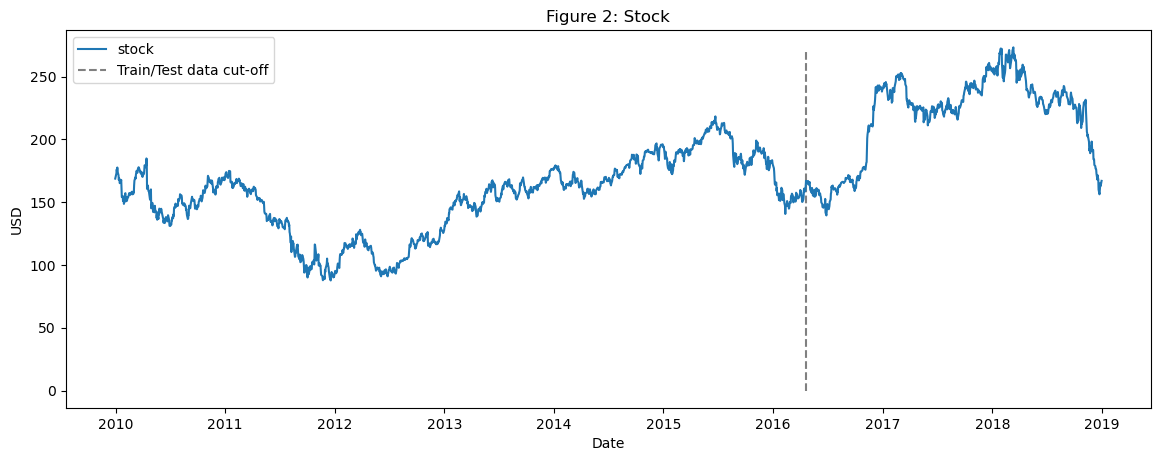

In [12]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Stock')
plt.legend()
plt.show()

In [13]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days,dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1585. Number of test days: 680.


In [14]:
import math

In [15]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
#     dataset['26ema'] = pd.ewma(dataset['price'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span = 26).mean()
    #dataset['12ema'] = pd.ewma(dataset['price'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span = 12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
#     dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)

    dataset['upper_band'] = dataset['ma21'] + 2*(dataset['Close'].rolling(20).std())
    dataset['lower_band'] = dataset['ma21'] - 2*(dataset['Close'].rolling(20).std())

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])

    return dataset

In [16]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])
dataset_TI_df = dataset_TI_df.drop(range(20))

In [94]:
dataset_TI_df.head(50)


,Close,ma7,ma21,26ema,12ema,MACD,upper_band,lower_band,ema,momentum,log_momentum
20,153.130005,152.374285,164.220476,160.321839,156.655072,-3.666767,183.435226,145.005726,152.113609,152.130005,5.024735
21,156.940002,152.777143,163.653809,160.014868,156.700047,-3.314821,182.615070,144.692549,155.331204,155.940002,5.049471
22,157.229996,153.098572,162.899047,159.766235,156.783365,-2.982871,181.006450,144.791644,156.597065,156.229996,5.051329
23,150.679993,153.069999,161.686666,158.967168,155.827031,-3.140137,179.567158,143.806174,152.652350,149.679993,5.008500
24,154.160004,153.449999,160.729523,158.550196,155.566566,-2.983631,177.033348,144.425699,153.657453,153.160004,5.031483
25,151.100006,153.137144,159.464286,157.912052,154.870357,-3.041695,174.714232,144.214340,151.952488,150.100006,5.011302
26,152.490005,153.675716,158.425238,157.452945,154.500079,-2.952866,172.645346,144.205131,152.310833,151.490005,5.020520
27,153.630005,153.747144,157.571429,157.132636,154.364964,-2.767672,171.078004,144.064854,153.190281,152.630005,5.028017
28,154.050003,153.334287,156.915715,156.876839,154.316124,-2.560714,169.227803,144.603626,153.763429,153.050003,5.030765
29,153.929993,152.862858,156.194762,156.634468,154.256321,-2.378146,167.107433,145.282090,153.874472,152.929993,5.029980


In [17]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

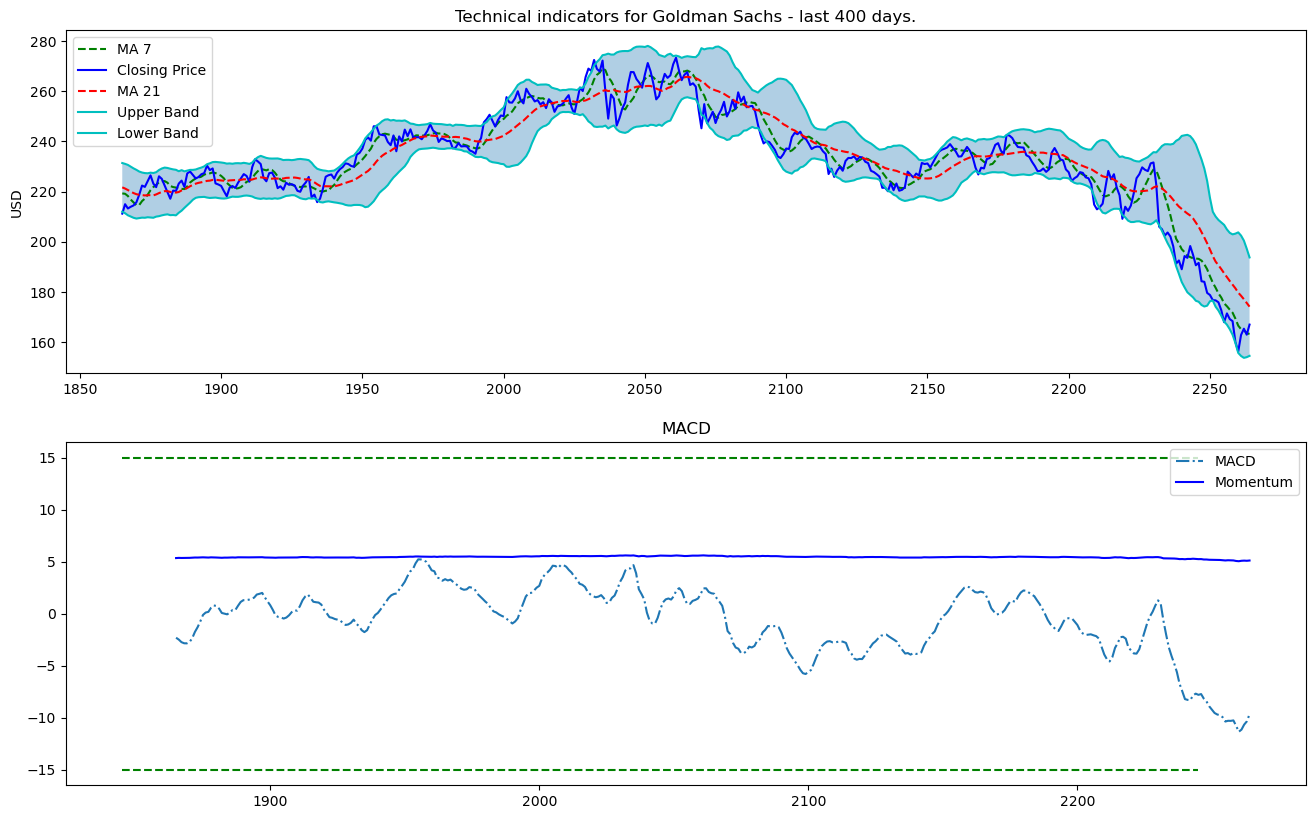

In [18]:
plot_technical_indicators(dataset_TI_df, 400)

In [19]:
import bert

In [20]:
data_FT = dataset_ex_df[['Date', 'Close']]


In [21]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

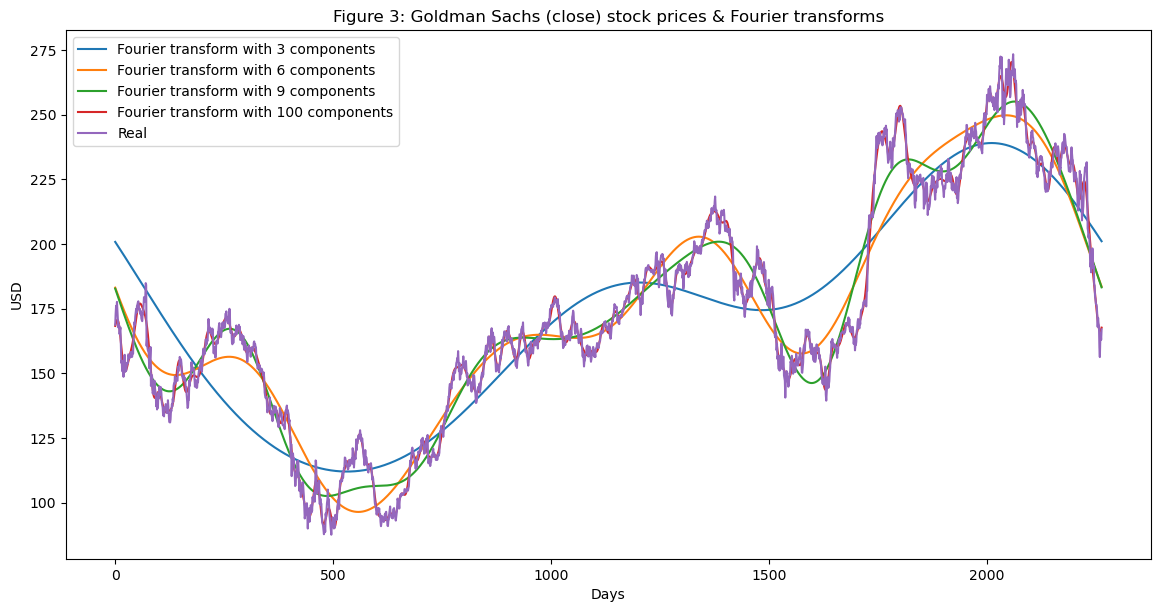

In [104]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()